# Using a Variational Autoencoder to detect anomalies in stock data

In [171]:
import pandas as pd
import yfinance as yf
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler

import tensorflow as tf
from keras import backend as K

from tensorflow.keras.layers import Input, concatenate, Reshape, Flatten, Concatenate
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.layers import BatchNormalization as BatchNorm
from tensorflow.keras import Model

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Get S&P500 ticker symbols
_ = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
SAP_500_TICKERS = list(_[0]['Symbol'])
SAP_500_TICKERS[:10]

['MMM', 'AOS', 'ABT', 'ABBV', 'ABMD', 'ACN', 'ATVI', 'ADM', 'ADBE', 'ADP']

In [3]:
DATA_SAVE_DIR = 'C:/_local/data_sets/'
DATA_SAVE_FILE_NAME = 's&p_500_5y_data.gz'
DATA_SAVE_PATH = DATA_SAVE_DIR + DATA_SAVE_FILE_NAME

## Load data

The following file was created using the Yahoo Finance API yfinance.

In [153]:
data_src = pd.read_csv(DATA_SAVE_PATH, index_col=['Date'], parse_dates=['Date'])

In [154]:
data_src.head()

,open,high,low,close,volume,dividends,stock_splits,open_ma_3,open_ma_5,open_ma_10,volume_ma_3,volume_ma_5,volume_ma_10,open_close,ticker,Adj Close
Date,,,,,,,,,,,,,,,,
2017-02-09,NaN,NaN,NaN,NaN,NaN,0.1000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AAL,NaN
2017-02-09,NaN,NaN,NaN,NaN,NaN,1.2200,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GWW,NaN
2017-02-09,NaN,NaN,NaN,NaN,NaN,0.1425,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AAPL,NaN
2017-02-09,NaN,NaN,NaN,NaN,NaN,0.4000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COF,NaN
2017-02-09,NaN,NaN,NaN,NaN,NaN,0.7500,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AMP,NaN


In [155]:
data_src.shape

(626436, 16)

## Data cleaning

In [389]:
data = data_src.copy()

# Adj close is nan for almost all entries
data = data.drop(['Adj Close'], axis=1)

# Delete moving average data
data = data.drop(
    ['open_ma_3', 'open_ma_5', 'open_ma_10', 'volume_ma_3', 'volume_ma_5', 'volume_ma_10'], axis=1
)

# Delete stock_splits data
data = data.drop(['dividends', 'stock_splits'], axis=1)

# Remove missing / bad values
data = data.replace([-np.Inf, np.Inf], np.nan)
data = data.dropna(how='any')

In [390]:
# Get first date for each ticker
ticker_date_groups = data[['ticker']].reset_index().groupby(['ticker']).min()
ticker_date_groups.value_counts()

Date      
2017-02-10    492
2020-03-19      2
2017-05-12      1
2018-04-26      1
2018-12-07      1
2019-03-12      1
2019-03-13      1
2019-03-20      1
2019-05-24      1
2021-05-14      1
2022-01-19      1
dtype: int64

In [391]:
# Remove tickers which do not have data on 2017-02-10
earliest_date = ticker_date_groups['Date'].min()
recently_added_tickers = list(ticker_date_groups[ticker_date_groups['Date']>earliest_date].index)

data = data[data['ticker'].isin(recently_added_tickers)==False]

# Subset data to only include top NUM_TICKERS tickers wrt total volume
NUM_TICKERS = 200

ticker_volume_means = data[['ticker', 'volume']].groupby(['ticker']).mean().sort_values('volume', ascending=False)
high_volume_tickers = list(ticker_volume_means.index[:NUM_TICKERS])

data = data[data['ticker'].isin(high_volume_tickers)==True]

# Get intra-day high-low
data['high_low'] = data['high'] - data['low']

# I did not include dates in this analysis because it is not as easy to visualize stock events which are anomalous due in 
# part because of the date. It is much easier to visualize anomalies as, e.g., a sharp increase in daily volume

# Extract days from dates
#data['day_of_week'] = data.index.dayofweek
#data['day_of_month'] = data.index.day
#data['month'] = data.index.month

# Convert date values into periodic representation
#data['day_of_week_sin'] = data['day_of_week'].map(lambda d: d * np.sin(2 * np.pi / 7))
#data['day_of_week_cos'] = data['day_of_week'].map(lambda d: d * np.cos(2 * np.pi / 7))
#data['day_of_month_sin'] = data['day_of_month'].map(lambda d: d * np.sin(2 * np.pi / 31))
#data['day_of_month_cos'] = data['day_of_month'].map(lambda d: d * np.cos(2 * np.pi / 31))
#data['month_sin'] = data['day_of_month'].map(lambda m: m * np.sin(2 * np.pi / 12))
#data['month_cos'] = data['day_of_month'].map(lambda m: m * np.cos(2 * np.pi / 12))
#data = data.drop(['day_of_week', 'day_of_month', 'month'], axis=1)

# Sort data into nicer format
data = data.sort_values(['Date', 'ticker'])
data.head()

data.head()

,open,high,low,close,volume,open_close,ticker,high_low
Date,,,,,,,,
2017-02-10,45.150656,45.228136,44.714838,44.986015,4040600.0,-0.164640,AAL,0.513298
2017-02-10,31.265862,31.379161,31.169085,31.185606,80262000.0,-0.080256,AAPL,0.210075
2017-02-10,48.343415,48.462586,47.882624,48.001793,5749200.0,-0.341622,ABBV,0.579962
2017-02-10,39.233299,39.288374,38.994630,39.233299,3692400.0,0.000000,ABT,0.293745
2017-02-10,116.510002,116.940002,115.029999,116.849998,2612900.0,0.339996,ADBE,1.910004


In [392]:
# Integer encoding of ticker symbols
ticker_label_encoder = LabelEncoder().fit(data['ticker'])
encoded_tickers = ticker_label_encoder.transform(data['ticker'])

# One-hot encoding of ticker symbols
one_hot_tickers = tf.keras.utils.to_categorical(encoded_tickers)
one_hot_tickers_df = pd.DataFrame(one_hot_tickers, index=data.index)

In [393]:
one_hot_tickers_df.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
Date,,,,,,,,,,,,,,,,,,,,,
2017-02-10,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-02-10,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-02-10,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-02-10,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-02-10,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [394]:
# Split data into training and testing
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(
    data, one_hot_tickers_df, test_size=.2, random_state=11
)

# Split training data into training and validation
X_train_df, X_valid_df, y_train_df, y_valid_df = train_test_split(
    X_train_df, y_train_df, test_size=.15, random_state=13
)

In [395]:
BATCH_SIZE = 32

# Truncate data to be multiple of batch size
train_truncate_val = X_train_df.shape[0] - X_train_df.shape[0] % BATCH_SIZE
valid_truncate_val = X_valid_df.shape[0] - X_valid_df.shape[0] % BATCH_SIZE
test_truncate_val = X_test_df.shape[0] - X_test_df.shape[0] % BATCH_SIZE

X_train_df = X_train_df.iloc[:train_truncate_val, :]
y_train_df = y_train_df.iloc[:train_truncate_val, :]

X_valid_df = X_valid_df.iloc[:valid_truncate_val, :]
y_valid_df = y_valid_df.iloc[:valid_truncate_val, :]

X_test_df = X_test_df.iloc[:test_truncate_val, :]
y_test_df = y_test_df.iloc[:test_truncate_val, :]

In [396]:
# Get numpy versions of dataframes for training
X_train = X_train_df.drop(['ticker'], axis=1).to_numpy()
y_train = y_train_df.to_numpy()

X_valid = X_valid_df.drop(['ticker'], axis=1).to_numpy()
y_valid = y_valid_df.to_numpy()

X_test = X_test_df.drop(['ticker'], axis=1).to_numpy()
y_test = y_test_df.to_numpy()

In [397]:
# Scale numeric data to N(0, 1)
data_scaler = MinMaxScaler().fit(X_train)

X_train = data_scaler.transform(X_train)
X_valid = data_scaler.transform(X_valid)
X_test = data_scaler.transform(X_test)

In [398]:
print(f'training x shape   --- {X_train_df.shape}    {y_train_df.shape} --- training y shape')
print(f'validation x shape ---- {X_valid_df.shape}    {y_valid_df.shape} --- validation y shape')
print(f'testing x shape    ---- {X_test_df.shape}    {y_test_df.shape} --- testing y shape')

training x shape   --- (171200, 8)    (171200, 200) --- training y shape
validation x shape ---- (30208, 8)    (30208, 200) --- validation y shape
testing x shape    ---- (50336, 8)    (50336, 200) --- testing y shape


## Creating Conditional Variational Autoencoder

The following conditional variational autoencoder is trained on batches of daily data. An ostensibly stronger model could be a recurrent model which encodes a sequence of data points for a given stock and then outputs an estimate for the next day's datapoint.

In [421]:
# Hyper-parameters
LATENT_DIM = 4

In [422]:
# CVAE dense
# CVAE input layers
X = Input(shape=(X_train.shape[1],), name='x_input')
Y = Input(shape=(y_train.shape[1],), name='y_input')

X_Y_concat = tf.keras.layers.concatenate([X, Y], name='x_y_concat')

# Encoder specification
encoder_dense_1 = Dense(128, activation='relu', name='encoder_dense_1')(X_Y_concat)
encoder_dense_2 = Dense(128, activation='relu', name='encoder_dense_2')(encoder_dense_1)
encoder_dropout = Dropout(.3, name='encoder_dropout')(encoder_dense_2)
encoder_dense_3 = Dense(128, activation='relu', name='encoder_dense_3')(encoder_dropout)

encoder_mu = Dense(LATENT_DIM, activation='linear', name='encoder_mu')(encoder_dense_3)
encoder_log_sigma = Dense(LATENT_DIM, activation='linear', name='encoder_log_sigma')(encoder_dense_3)

encoder = Model([X, Y], encoder_mu, name='encoder')
encoder.summary()

# Reparameterization and concatenation layers / specification
def sample_and_reparameterize(mu_logsigma):
    mu, log_sigma = mu_logsigma
    eps = K.random_normal(shape=(LATENT_DIM,))
    return mu + K.exp(log_sigma * .5) * eps

Z = tf.keras.layers.Lambda(sample_and_reparameterize, output_shape=(LATENT_DIM,), 
                        name='sample_and_reparameterize')([encoder_mu, encoder_log_sigma])

Z_Y_concat = tf.keras.layers.concatenate([Z, Y], name='z_y_concat')

# Decoder layers
decoder_dense_layer_1 = Dense(128, activation='relu', name='decoder_dense_1')
decoder_dense_layer_2 = Dense(128, activation='relu', name='decoder_dense_2')
decoder_dropout_layer = Dropout(.3, name='decoder_dropout')
decoder_dense_layer_3 = Dense(128, activation='relu', name='decoder_dense_3')
decoder_output_layer = Dense(X_train.shape[1], activation='sigmoid', name='decoder_output')

# Decoder specification
d1 = decoder_dense_layer_1(Z_Y_concat)
d2 = decoder_dense_layer_2(d1)
d3 = decoder_dropout_layer(d2)
d4 = decoder_dense_layer_3(d3)
cvae_output = decoder_output_layer(d4)

decoder_input = Input(shape=(LATENT_DIM+y_train.shape[1],), name='decoder_input')
decoder_dense_1 = decoder_dense_layer_1(decoder_input)
decoder_dense_2 = decoder_dense_layer_2(decoder_dense_1)
decoder_dropout = decoder_dropout_layer(decoder_dense_2)
decoder_dense_3 = decoder_dense_layer_3(decoder_dropout)
decoder_output = decoder_output_layer(decoder_dense_3)

decoder = Model(decoder_input, decoder_output, name='decoder')
decoder.summary()

cvae = Model([X, Y], cvae_output, name='cvae')
cvae.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 x_input (InputLayer)           [(None, 7)]          0           []                               
                                                                                                  
 y_input (InputLayer)           [(None, 200)]        0           []                               
                                                                                                  
 x_y_concat (Concatenate)       (None, 207)          0           ['x_input[0][0]',                
                                                                  'y_input[0][0]']                
                                                                                                  
 encoder_dense_1 (Dense)        (None, 128)          26624       ['x_y_concat[0][0]']       

In [423]:
# Loss functions
def reconstruction_loss(x_true, x_pred):
    square_error = (x_true - x_pred) ** 2
    return K.mean( K.sum(square_error, axis=1), axis=0 )

def kl_divergence(x_true, x_pred, emu, els):
    
    kl = K.exp(els) + K.square(emu) - 1 - els
    return .5 * K.sum(kl, axis=1)

def vae_loss(x_true, x_pred, emu, els):
    return reconstruction_loss(x_true, x_pred) + kl_divergence(x_true, x_pred, emu, els)

## Model training

In [424]:
if len(cvae.losses) == 0:
    cvae.add_loss(vae_loss(X, cvae_output, encoder_mu, encoder_log_sigma))
    
if len(cvae.metrics) == 0:
    cvae.add_metric(reconstruction_loss(X, cvae_output), name='reconstruction_loss')
    cvae.add_metric(kl_divergence(X, cvae_output, encoder_mu, encoder_log_sigma), name='kl_divergence')
    
cvae.compile(optimizer=tf.keras.optimizers.Adam(1e-3))

early_stop_clbk = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=4)
reduce_lr_clbk = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=2)

callbacks = [early_stop_clbk, reduce_lr_clbk]

cvae_training_history = cvae.fit(
    x=[X_train, y_train], y=X_train,
    epochs=45,
    validation_data=([X_valid, y_valid], X_valid),
    callbacks=callbacks
).history

Epoch 1/45
5350/5350 [==============================] - 27s 5ms/step - loss: 0.0084 - reconstruction_loss: 0.0084 - kl_divergence: 5.3936e-05 - val_loss: 0.0022 - val_reconstruction_loss: 0.0022 - val_kl_divergence: 1.2580e-07 - lr: 0.0010
Epoch 2/45
5350/5350 [==============================] - 26s 5ms/step - loss: 0.0026 - reconstruction_loss: 0.0026 - kl_divergence: 9.0129e-07 - val_loss: 0.0022 - val_reconstruction_loss: 0.0022 - val_kl_divergence: 2.3690e-07 - lr: 0.0010
Epoch 3/45
5350/5350 [==============================] - 26s 5ms/step - loss: 0.0024 - reconstruction_loss: 0.0024 - kl_divergence: 6.0856e-07 - val_loss: 0.0021 - val_reconstruction_loss: 0.0021 - val_kl_divergence: 8.7723e-08 - lr: 0.0010
Epoch 4/45
5350/5350 [==============================] - 26s 5ms/step - loss: 0.0024 - reconstruction_loss: 0.0024 - kl_divergence: 6.0332e-07 - val_loss: 0.0021 - val_reconstruction_loss: 0.0021 - val_kl_divergence: 1.2925e-09 - lr: 0.0010
Epoch 5/45
5350/5350 [==================

## Evaluate model on test data

In [425]:
# Calculate loss and metrics over test set
cvae.evaluate(x=[X_test, y_test], y=X_test,
              batch_size=BATCH_SIZE
             );

1573/1573 [==============================] - 5s 3ms/step - loss: 0.0023 - reconstruction_loss: 0.0023 - kl_divergence: -2.2421e-09


## Get number of anomalies per stock in subset of test data

In [426]:
# It would take about 20 mins to get the individual loss and metrics for each observation in the test set
# since we have to evaluate with batches of size 1, 
# so we will only look at a subset of the test data (the following next takes about 2 minute for 1500 samples)

np.random.seed(20)
test_evaluation_indices = np.random.choice(np.arange(X_test.shape[0]), replace=False, size=1500)

In [427]:
%%time

# Get reconstruction error for each observation in subset of test set
test_index_recon_loss_dict = {}
for index in test_evaluation_indices:
        
    X = X_test[index:index+1, :]
    y = y_test[index:index+1, :]
    
    loss_dict = cvae.evaluate(x=[X, y], y=y, 
                              batch_size=1, return_dict=True, verbose=0)
    
    test_index_recon_loss_dict[index] = loss_dict['reconstruction_loss']

Wall time: 2min 7s


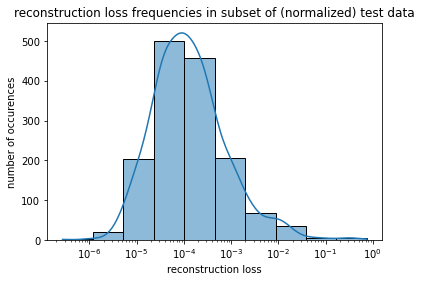

In [428]:
ax = plt.gca()

sns.histplot(data=test_index_recon_loss_dict.values(), bins=10, kde=True, log_scale=True, legend=False)
ax.set_xlabel('reconstruction loss')
ax.set_ylabel('number of occurences')
ax.set_title('reconstruction loss frequencies in subset of (normalized) test data');

In [429]:
def print_high_reconstruction_loss_percentiles(losses):
    print(f'90th percentile: {np.percentile(losses, 90)}')
    print(f'95th percentile: {np.percentile(losses, 95)}')
    print(f'97.5th percentile: {np.percentile(losses, 97.5)}')
    print(f'99th percentile: {np.percentile(losses, 99)}')

In [430]:
print('reconstruction_loss percentiles in subset of test set')
print_high_reconstruction_loss_percentiles(list(test_index_recon_loss_dict.values()))

reconstruction_loss percentiles in subset of test set
90th percentile: 0.0012546759564429544
95th percentile: 0.003594715020153668
97.5th percentile: 0.009952121623791752
99th percentile: 0.018006106484681365


In [431]:
# We'll consider any reconstruction loss above ANOMALY_THRESHOLD_VALUE as anomalous
ANOMALY_THRESHOLD_VALUE = np.percentile(list(test_index_recon_loss_dict.values()), 99)
print('anomaly threshold reconstruction value: ', ANOMALY_THRESHOLD_VALUE)

anomaly threshold reconstruction value:  0.018006106484681365


In [432]:
anomalous_test_set_indices = [index for 
                              index, recon_loss in test_index_recon_loss_dict.items()
                              if recon_loss >= ANOMALY_THRESHOLD_VALUE
                             ]

In [433]:
anomalies_per_ticker_df = X_test_df['ticker'].iloc[anomalous_test_set_indices].value_counts()
most_anomalous_stocks = list(anomalies_per_ticker_df.index)
anomalies_per_ticker_df

AMZN    8
AMD     2
OXY     1
NFLX    1
NVDA    1
F       1
TSLA    1
Name: ticker, dtype: int64

## Finding anomalies in a particular stock

In [443]:
anomalous_stock = 'F' # Ford

anomalous_stock_df = data[data['ticker'] == anomalous_stock].drop(['ticker'], axis=1).sort_index()
X_anomalous_stock_np = anomalous_stock_df.to_numpy()
X_anomalous_stock_np = data_scaler.transform(X_anomalous_stock_np)
anomalous_stock_df = pd.DataFrame(X_anomalous_stock_np, 
                                  columns=list(anomalous_stock_df.columns), index=anomalous_stock_df.index)

anomalous_stock_one_hot_id = ticker_label_encoder.transform([anomalous_stock])[0]
y_anomalous_stock_np = [0] * anomalous_stock_one_hot_id + [1] + [0] * (NUM_TICKERS - anomalous_stock_one_hot_id - 1)

anomalous_stock_df.head()

,open,high,low,close,volume,open_close,high_low
Date,,,,,,,
2017-02-10,0.002536,0.002529,0.002566,0.002560,0.077364,0.507752,0.000424
2017-02-13,0.002558,0.002553,0.002591,0.002571,0.057382,0.507613,0.000424
2017-02-14,0.002580,0.002570,0.002615,0.002591,0.066483,0.507585,0.000333
2017-02-15,0.002575,0.002557,0.002606,0.002586,0.058883,0.507585,0.000273
2017-02-16,0.002573,0.002557,0.002591,0.002567,0.053683,0.507364,0.000485


In [444]:
%%time
def get_reconstruction_loss(row, ticker_one_hot):
    
    x = np.expand_dims(row.to_numpy(), axis=0)
    y = np.expand_dims(ticker_one_hot, axis=0)
    
    return cvae.evaluate(x=[x, y], y=x, batch_size=1, return_dict=True, verbose=0)['reconstruction_loss']

# Get reconstruction loss for each observation of anomalous_stock
get_anomalous_stock_reconstruction_loss = lambda r: get_reconstruction_loss(r, y_anomalous_stock_np)

if not 'reconstruction_loss' in anomalous_stock_df.columns:
    anomalous_stock_df['reconstruction_loss'] = anomalous_stock_df.apply(get_anomalous_stock_reconstruction_loss, axis=1)

# Print large percentiles for reconstruction losses
print(f'reconstruction losses for {anomalous_stock}')
print_high_reconstruction_loss_percentiles(list(anomalous_stock_df['reconstruction_loss']))

# Get reconstruction loss threshold for determining anomalies
anomaly_threshold = np.percentile(list(anomalous_stock_df['reconstruction_loss']), 99)

# Get dates of anomalies
anomalous_stock_anomaly_dates = anomalous_stock_df[anomalous_stock_df['reconstruction_loss'] >= anomaly_threshold].index
print(f'\nnumber of anomalies: {len(anomalous_stock_anomaly_dates)}\n')

reconstruction losses for F
90th percentile: 0.010192832164466389
95th percentile: 0.021856634691357586
97.5th percentile: 0.04117615800350904
99th percentile: 0.10010620996356095

number of anomalies: 13

Wall time: 1min 46s


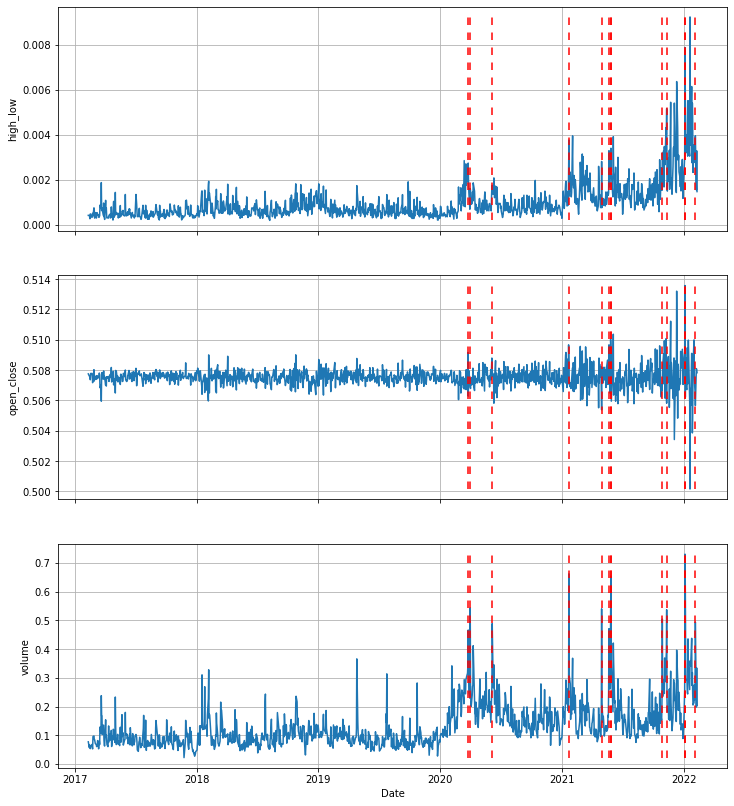

In [445]:
# We plot the high_low, open_close, and volume for Ford on each day in the dataset
# We place vertical lines on days where our model's reconstruction loss is in the 99th percentile
# In particular, the model has high reconstruction loss for dates where there was a spike in one of those variables

plot_vars = ['high_low', 'open_close', 'volume']

fig, axs = plt.subplots(len(plot_vars), 1, sharex=True, figsize=(12, 14))
for a, (ax, var) in enumerate( zip(axs, plot_vars) ):
    
    if isinstance(var, tuple):
        sns.lineplot(data=anomalous_stock_df[[var[0]]], x='Date', y=var[0], ax=ax)
        sns.lineplot(data=anomalous_stock_df[[var[1]]], x='Date', y=var[1], ax=ax)
        
        ymin = anomalous_stock_df[var[0]].min()
        ymax = anomalous_stock_df[var[0]].max()
        
    else:
        sns.lineplot(data=anomalous_stock_df[[var]], x='Date', y=var, ax=ax)
        ymin = anomalous_stock_df[var].min()
        ymax = anomalous_stock_df[var].max()
    
            
    ax.vlines(x=anomalous_stock_anomaly_dates, ymin=ymin, ymax=ymax, color='red', linestyle=(0, (5, 5)))
    
    ax.grid(True)
    ax.set_ylabel(var)

In [446]:
sorted(anomalous_stock_anomaly_dates)

[Timestamp('2020-03-25 00:00:00'),
 Timestamp('2020-03-31 00:00:00'),
 Timestamp('2020-06-05 00:00:00'),
 Timestamp('2021-01-21 00:00:00'),
 Timestamp('2021-04-29 00:00:00'),
 Timestamp('2021-05-21 00:00:00'),
 Timestamp('2021-05-26 00:00:00'),
 Timestamp('2021-05-27 00:00:00'),
 Timestamp('2021-10-28 00:00:00'),
 Timestamp('2021-11-10 00:00:00'),
 Timestamp('2022-01-04 00:00:00'),
 Timestamp('2022-01-05 00:00:00'),
 Timestamp('2022-02-04 00:00:00')]

Looking up some of the dates with high reconstruction losses...

*2020-03-25* <br>
Ford: Kentucky Truck Plant worker contracts coronavirus <br>
https://www.wdrb.com/in-depth/ford-kentucky-truck-plant-worker-contracts-coronavirus/article_b7c80756-6ef9-11ea-8435-4767ffb821e0.html <br>
"Ford's U.S. plants, in Kentucky Truck Plant and Louisville Assembly Plant, are shut down indefinitely starting this week because of the outbreak."

<br> *2020-03-31* <br>
1. Ford slashes vehicle production at six plants in North America due to chip shortage
    https://www.cnbc.com/2021/03/31/ford-slashes-vehicle-production-at-seven-plants-in-north-america-due-to-chip-shortage.html <br>

2. Ford postpones reopening ‘key’ plants due to coronavirus pandemic
    https://www.cnbc.com/2020/03/31/ford-postpones-reopening-key-plants-due-to-coronavirus-pandemic.html

<br> *2021-01-21* <br>
Ford shares on pace for best week since June on new products, earnings expectations
https://www.cnbc.com/2021/01/21/ford-shares-on-pace-for-best-week-since-june-on-new-products.html

<br> *2021-05-21* <br>
Ford CEO: F-150 Lightning has nearly 45,000 reservations
https://www.detroitnews.com/story/business/autos/ford/2021/05/21/ford-ceo-says-automaker-has-more-than-44-500-f-150-lightning-deposits/5204444001/